In [1]:
import os
import pandas as pd

In [2]:
train_image_dir = "train/images"
train_csv = "train.csv"

val_image_dir = "val/images"
val_csv = "val.csv"

test_image_dir = "test/images"
test_csv = "test.csv"


In [3]:
df_train = pd.read_csv(train_csv)
df_val = pd.read_csv(val_csv)
df_test = pd.read_csv(test_csv)


In [4]:
for df in [df_train, df_val, df_test]:
    if "image" in df.columns:
        df.rename(columns={"image": "image_id"}, inplace=True)

def keep_existing(df, img_dir, img_col="image_id"):
    df = df.dropna(subset=["thickness"]).reset_index(drop=True)
    mask = df[img_col].apply(
        lambda x: os.path.exists(os.path.join(img_dir, f"{x}.jpg")) or
                  os.path.exists(os.path.join(img_dir, f"{x}.png"))
    )
    return df[mask].reset_index(drop=True)



In [5]:
df_train = keep_existing(df_train, train_image_dir)
df_val = keep_existing(df_val, val_image_dir)
df_test = keep_existing(df_test, test_image_dir)

thickness_mean = df_train["thickness"].mean()
thickness_std = df_train["thickness"].std()


In [6]:
df_train["thickness"] = (df_train["thickness"] - thickness_mean) / (thickness_std + 1e-7)
df_val["thickness"] = (df_val["thickness"] - thickness_mean) / (thickness_std + 1e-7)
df_test["thickness"] = (df_test["thickness"] - thickness_mean) / (thickness_std + 1e-7)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_train["label_enc"] = le.fit_transform(df_train["label"].astype(str))
df_val["label_enc"] = le.transform(df_val["label"].astype(str))
df_test["label_enc"] = le.transform(df_test["label"].astype(str))


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


class DermaDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_name = row["image_id"]
        pjpg = os.path.join(self.img_dir, f"{img_name}.jpg")
        ppng = os.path.join(self.img_dir, f"{img_name}.png")

        if os.path.exists(pjpg):
            img = Image.open(pjpg).convert("RGB")
        elif os.path.exists(ppng):
            img = Image.open(ppng).convert("RGB")
        else:
            raise FileNotFoundError(img_name)

        img = self.transform(img)

        label = int(row["label_enc"])
        label = torch.tensor(label, dtype=torch.long)

        thickness = torch.tensor(float(row["thickness"]), dtype=torch.float32)

        return img, label, thickness


In [9]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(518, scale=(0.7, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=20, translate=(0.15, 0.15), scale=(0.85, 1.05)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.25),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize(518, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(518),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_set = DermaDataset(df_train, train_image_dir, train_transform)
val_set = DermaDataset(df_val, val_image_dir, val_transform)
test_set = DermaDataset(df_test, test_image_dir, val_transform)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)



In [10]:
import torch
import torch.nn as nn
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "dino_derma_classifier.pth"

state = torch.load(model_path, map_location="cpu")

backbone = timm.create_model("vit_base_patch14_dinov2", pretrained=False)

filtered_state = {
    k: v for k, v in state.items()
    if not k.startswith("head")
}

missing, unexpected = backbone.load_state_dict(filtered_state, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

embed_dim = backbone.embed_dim

backbone.head = nn.Identity()

for p in backbone.parameters():
    p.requires_grad = False

for p in backbone.blocks[-3:].parameters():
    p.requires_grad = True
for p in backbone.norm.parameters():
    p.requires_grad = True

backbone = backbone.to(device)

print("Loaded backbone using vit_base_patch14_dinov2")
print("Embed dim:", embed_dim)
print("Trainable params:", sum(p.requires_grad for p in backbone.parameters()))


Missing keys: []
Unexpected keys: []
Loaded backbone using vit_base_patch14_dinov2
Embed dim: 768
Trainable params: 44


In [11]:
class_head = nn.Sequential(
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, 1024),
    nn.GELU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(256, len(le.classes_))
)

reg_head = nn.Sequential(
    nn.LayerNorm(embed_dim),
    nn.Linear(embed_dim, 768),
    nn.GELU(),
    nn.Dropout(0.4),
    nn.Linear(768, 256),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.GELU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)
)

In [12]:
class MultiTaskModel(nn.Module):
    def __init__(self, backbone, class_head, reg_head):
        super().__init__()
        self.backbone = backbone
        self.class_head = class_head
        self.reg_head = reg_head

    def forward(self, x):
        feat = self.backbone.forward_features(x)

        if feat.dim() == 3:
            feat = feat[:, 0]

        cls = self.class_head(feat)
        reg = self.reg_head(feat).squeeze(1)
        return cls, reg


In [13]:
model = MultiTaskModel(backbone, class_head, reg_head).to(device)


In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

ce_loss = nn.CrossEntropyLoss(label_smoothing=0.15)
mse_loss = nn.MSELoss()

opt_params = [
    {'params': model.backbone.blocks[-3:].parameters(), 'lr': 3e-5},
    {'params': model.backbone.norm.parameters(), 'lr': 3e-5},
    {'params': model.class_head.parameters(), 'lr': 2e-3},
    {'params': model.reg_head.parameters(), 'lr': 2e-3}
]
optimizer = optim.AdamW(opt_params, weight_decay=0.03, betas=(0.9, 0.999))
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=12, T_mult=1, eta_min=1e-7)



In [15]:
import torch
import math

def compute_metrics(preds_reg, targets_reg, preds_cls, targets_cls):
    preds_reg = preds_reg.detach().cpu()
    targets_reg = targets_reg.detach().cpu()
    preds_cls = preds_cls.detach().cpu()
    targets_cls = targets_cls.detach().cpu()
    
    mae = torch.mean(torch.abs(preds_reg - targets_reg)).item()
    rmse = math.sqrt(torch.mean((preds_reg - targets_reg)**2).item())
    mape = torch.mean(torch.abs((preds_reg - targets_reg) / (torch.abs(targets_reg) + 1e-7))).item()
    acc = (preds_cls.argmax(1) == targets_cls).float().mean().item()
    
    return mae, rmse, mape, acc


In [16]:
history = {
    "train_loss": [], "val_loss": [], "test_loss": [],
    "train_ce": [], "val_ce": [], "test_ce": [],
    "train_mse": [], "val_mse": [], "test_mse": [],
    "train_mae": [], "val_mae": [], "test_mae": [],
    "train_rmse": [], "val_rmse": [], "test_rmse": [],
    "train_mape": [], "val_mape": [], "test_mape": [],
    "train_acc": [], "val_acc": [], "test_acc": []
}

In [17]:
from tqdm import tqdm
import torch

def to_class_indices(labels):
    if labels.dim() == 2:
        return labels.argmax(dim=1).long()
    return labels.long()

def eval_loader(loader):
    model.eval()
    total_ce = 0.0
    total_mse = 0.0
    count = 0
    all_preds_reg = []
    all_targets_reg = []
    all_preds_cls = []
    all_targets_cls = []
    
    with torch.no_grad():
        for imgs, labels, th in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            th = th.to(device)
            cls_out, reg_out = model(imgs)
            loss_ce = ce_loss(cls_out, labels)
            loss_mse = mse_loss(reg_out, th)
            total_ce += loss_ce.item() * imgs.size(0)
            total_mse += loss_mse.item() * imgs.size(0)
            count += imgs.size(0)
            all_preds_reg.append(reg_out.cpu())
            all_targets_reg.append(th.cpu())
            all_preds_cls.append(cls_out.cpu())
            all_targets_cls.append(labels.cpu())
    
    preds_reg = torch.cat(all_preds_reg, dim=0)
    targets_reg = torch.cat(all_targets_reg, dim=0)
    preds_cls = torch.cat(all_preds_cls, dim=0)
    targets_cls = torch.cat(all_targets_cls, dim=0)
    mae, rmse, mape, acc = compute_metrics(preds_reg, targets_reg, preds_cls, targets_cls)
    
    return total_ce / count, total_mse / count, mae, rmse, mape, acc

best_val_rmse = float("inf")
alpha = 1.0
beta = 1.5
patience = 3
patience_counter = 0
epochs = 8

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    for imgs, labels, th in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        th = th.to(device)

        optimizer.zero_grad()
        cls_out, reg_out = model(imgs)

        loss_ce = ce_loss(cls_out, labels)
        loss_mse = mse_loss(reg_out, th)
        total_loss = alpha * loss_ce + beta * loss_mse
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.2)
        optimizer.step()

        pbar.set_postfix({'loss': total_loss.item(), 'ce': loss_ce.item(), 'mse': loss_mse.item()})

    scheduler.step()

    train_ce, train_mse, train_mae, train_rmse, train_mape, train_acc = eval_loader(train_loader)
    val_ce, val_mse, val_mae, val_rmse, val_mape, val_acc = eval_loader(val_loader)
    test_ce, test_mse, test_mae, test_rmse, test_mape, test_acc = eval_loader(test_loader)

    history["train_loss"].append(alpha * train_ce + beta * train_mse)
    history["val_loss"].append(alpha * val_ce + beta * val_mse)
    history["test_loss"].append(alpha * test_ce + beta * test_mse)
    history["train_ce"].append(train_ce); history["val_ce"].append(val_ce); history["test_ce"].append(test_ce)
    history["train_mse"].append(train_mse); history["val_mse"].append(val_mse); history["test_mse"].append(test_mse)
    history["train_mae"].append(train_mae); history["val_mae"].append(val_mae); history["test_mae"].append(test_mae)
    history["train_rmse"].append(train_rmse); history["val_rmse"].append(val_rmse); history["test_rmse"].append(test_rmse)
    history["train_mape"].append(train_mape); history["val_mape"].append(val_mape); history["test_mape"].append(test_mape)
    history["train_acc"].append(train_acc); history["val_acc"].append(val_acc); history["test_acc"].append(test_acc)

    print(f"Epoch {epoch+1} | Loss: {history['train_loss'][-1]:.4f} | Val RMSE: {val_rmse:.4f} | Val Acc: {val_acc:.4f} | Val MAPE: {val_mape:.4f}")

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        patience_counter = 0
        torch.save(model.state_dict(), "best_thickness_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 1/8: 100%|██████████| 45/45 [00:59<00:00,  1.32s/it, loss=1.04, ce=0.396, mse=0.43]   


Epoch 1 | Loss: 1.7453 | Val RMSE: 1.3267 | Val Acc: 0.9274 | Val MAPE: 0.4698


Epoch 2/8: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it, loss=1.39, ce=0.432, mse=0.639]  


Epoch 2 | Loss: 1.5494 | Val RMSE: 1.2413 | Val Acc: 0.9402 | Val MAPE: 0.5636


Epoch 3/8: 100%|██████████| 45/45 [00:58<00:00,  1.29s/it, loss=0.991, ce=0.364, mse=0.418] 


Epoch 3 | Loss: 1.2060 | Val RMSE: 1.1369 | Val Acc: 0.9402 | Val MAPE: 0.8522


Epoch 4/8: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it, loss=2.55, ce=0.33, mse=1.48]    


Epoch 4 | Loss: 1.0526 | Val RMSE: 1.0862 | Val Acc: 0.9466 | Val MAPE: 0.9675


Epoch 5/8: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it, loss=1.84, ce=0.531, mse=0.874]  


Epoch 5 | Loss: 0.9313 | Val RMSE: 1.0186 | Val Acc: 0.8868 | Val MAPE: 0.7610


Epoch 6/8: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it, loss=0.616, ce=0.363, mse=0.169] 


Epoch 6 | Loss: 0.7206 | Val RMSE: 0.9163 | Val Acc: 0.9444 | Val MAPE: 0.5242


Epoch 7/8: 100%|██████████| 45/45 [00:58<00:00,  1.30s/it, loss=1.46, ce=0.324, mse=0.759]  


Epoch 7 | Loss: 0.7338 | Val RMSE: 0.9170 | Val Acc: 0.9573 | Val MAPE: 0.9850


Epoch 8/8: 100%|██████████| 45/45 [00:58<00:00,  1.29s/it, loss=0.584, ce=0.282, mse=0.201] 


Epoch 8 | Loss: 0.5646 | Val RMSE: 0.8289 | Val Acc: 0.9359 | Val MAPE: 0.4631


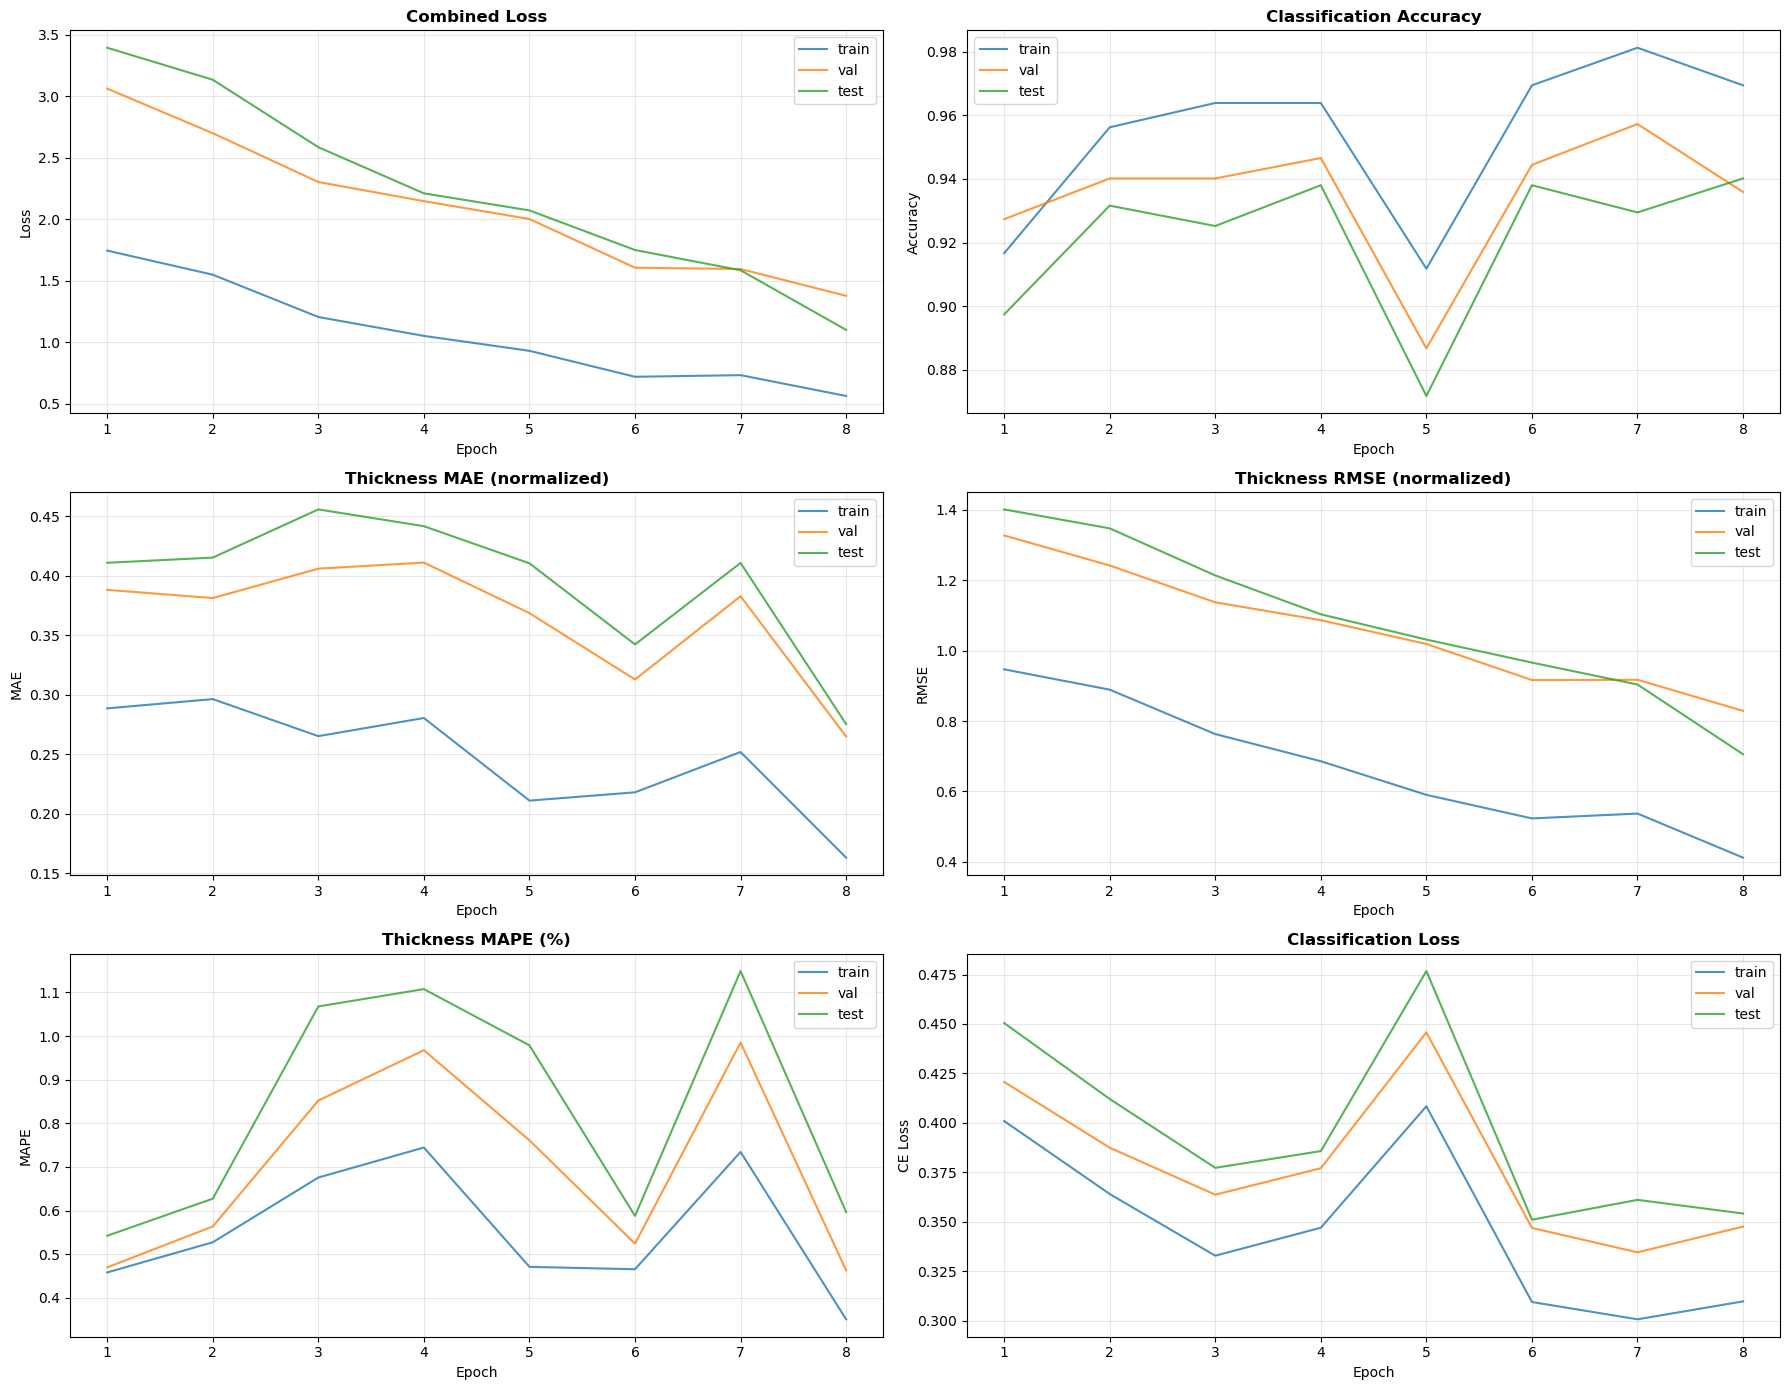

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 14))

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.subplot(3, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_loss"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_loss"], label="test", alpha=0.8)
plt.title("Combined Loss", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_acc"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_acc"], label="test", alpha=0.8)
plt.title("Classification Accuracy", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 3)
plt.plot(epochs_range, history["train_mae"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_mae"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_mae"], label="test", alpha=0.8)
plt.title("Thickness MAE (normalized)", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
plt.plot(epochs_range, history["train_rmse"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_rmse"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_rmse"], label="test", alpha=0.8)
plt.title("Thickness RMSE (normalized)", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.plot(epochs_range, history["train_mape"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_mape"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_mape"], label="test", alpha=0.8)
plt.title("Thickness MAPE (%)", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
plt.plot(epochs_range, history["train_ce"], label="train", alpha=0.8)
plt.plot(epochs_range, history["val_ce"], label="val", alpha=0.8)
plt.plot(epochs_range, history["test_ce"], label="test", alpha=0.8)
plt.title("Classification Loss", fontsize=12, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_metrics.png", dpi=150, bbox_inches='tight')
plt.show()



In [21]:
model.load_state_dict(torch.load("best_thickness_model.pth"))



<All keys matched successfully>

In [22]:
print(f"\nBest validation RMSE (normalized): {best_val_rmse:.4f}")
print(f"\nFinal test metrics (normalized):")
print(f"  MAE: {history['test_mae'][-1]:.4f}")
print(f"  RMSE: {history['test_rmse'][-1]:.4f}")
print(f"  Accuracy: {history['test_acc'][-1]:.4f}")
print(f"  MAPE: {history['test_mape'][-1]:.4f}")

unnorm_test_mae = history['test_mae'][-1] * thickness_std
unnorm_test_rmse = history['test_rmse'][-1] * thickness_std

print(f"\nFinal test metrics (mm units):")
print(f"  MAE: {unnorm_test_mae:.4f} mm")
print(f"  RMSE: {unnorm_test_rmse:.4f} mm")


Best validation RMSE (normalized): 0.8289

Final test metrics (normalized):
  MAE: 0.2752
  RMSE: 0.7057
  Accuracy: 0.9402
  MAPE: 0.5969

Final test metrics (mm units):
  MAE: 0.1341 mm
  RMSE: 0.3438 mm
